# Spotify Song Analysis

The goal of this notebook is to analyze a dataset of songs from Spotify to uncover patterns by running cluster analysis. As a result songs with similar characteristics will be grouped in playlists.

In [237]:
import pandas as pd
import numpy as np
import altair as alt

In [238]:
# load data from gustavos github

username = "datagus"
repository = "ASDA2025"
directory = "refs/heads/main/datasets/homework_week11/6.3.3_spotify_5000_songs.csv"
github_url = f"https://raw.githubusercontent.com/{username}/{repository}/{directory}"
df = pd.read_csv(github_url)

In [239]:
#clean / strip data
df.columns = df.columns.str.strip()

In [240]:
df.columns

Index(['name', 'artist', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 'id', 'html'],
      dtype='object')

Hot encode categorical variables first

In [241]:

# df_encoded = pd.get_dummies(
#     df,
#     columns=["key", "mode", "time_signature"],
#     drop_first=False)
#
# df_encoded = df_encoded.copy()
#
# bool_cols = df_encoded.select_dtypes(include="bool").columns
# df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)

In [242]:
#identify numerical columns
# df_encoded.select_dtypes(include="number").columns.tolist()

In [243]:
clustering_features = df.select_dtypes(include="number").columns.tolist()

# enable if using hot encoded data
#clustering_features = df_encoded.select_dtypes(include="number").columns.tolist()


# Create a dataframe with only these features
X = df[clustering_features].copy()

# enable if using hot encoded data
# X = df_encoded[clustering_features].copy()


X = X.dropna(axis=0)

## Normalizing the data
This is done to ensure that all features contribute equally to the distance calculations during clustering. This is a preparation for k-means clustering algorithm.

In [244]:
print(X.columns.tolist())


['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']


In [245]:
mins = X.min()
maxs = X.max()

# Min-Max normalization
# Formula: (value - min) / (max - min)
X_normalized = (X - mins) / (maxs - mins)* 9 + 1

In [246]:
X_normalized.describe()


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,5235.000000,5235.000000,5235.000000,5235.000000,5235.000000,5235.000000,5235.000000,5235.000000,5235.000000,5235.000000,5235.000000,5235.000000,5235.000000
mean,5.742013,6.882082,5.299088,8.433033,6.816046,1.815473,3.620872,3.351299,2.690154,5.053165,5.993190,1.511855,8.025330
std,2.029337,2.595015,2.922185,0.923570,4.303668,0.697972,3.216729,3.386981,1.362399,2.537590,1.201534,0.322677,0.756584
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.875905,5.311000,2.636364,8.139757,1.000000,1.382353,1.022139,1.000009,1.843465,2.790863,5.044890,1.374060,8.200000
50%,6.016546,7.642000,5.090909,8.726484,10.000000,1.547059,1.862048,1.017178,2.139818,4.810152,6.012477,1.456556,8.200000
75%,7.403309,9.037000,7.545455,9.030778,10.000000,1.967157,6.109940,6.875127,3.161094,7.185787,6.636576,1.568497,8.200000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


## Initalize K-Means Clustering and Assign each point to a Cluster

In [247]:
# Number of clusters
k = 7

# Randomly sample k rows from the dataframe as initial centroids
centroids = X_normalized.sample (k, random_state=42)
centroids

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
3075,6.230610,8.0470,10.000000,9.109566,1.0,1.419608,2.219880,1.000132,3.571429,4.572589,6.554185,1.354542,8.2
1268,7.375388,6.1390,2.636364,8.097796,10.0,1.293137,4.027108,1.000022,2.951368,8.940102,6.120020,1.360219,8.2
422,5.681489,5.0230,7.545455,7.859085,10.0,3.647059,6.981928,1.000113,4.109422,7.222335,5.679546,1.262330,8.2
2543,5.579111,2.8450,8.363636,8.557758,1.0,1.565686,9.882530,9.159391,2.112462,1.995939,6.396677,1.659698,8.2
2842,5.709411,7.5340,5.090909,8.928075,1.0,1.358824,1.027831,1.000736,3.425532,3.430457,6.385280,1.408382,8.2
5157,1.623578,1.4527,1.000000,5.814564,10.0,1.414706,9.683735,8.830457,1.836170,1.320711,4.056147,4.212285,8.2
4460,3.540848,9.7390,7.545455,8.785172,1.0,2.382353,1.007120,5.038579,4.683891,2.315736,5.257283,1.441901,8.2


In [248]:
# Initialize a DataFrame to store distances from each point to each centroid
distances = pd.DataFrame()


# Calculate distance from each point to each centroid
for i in range(k):
    # Get the i-th centroid as a pandas Series
    centroid_i = centroids.iloc[i]

     # Subtract centroid from all rows in X_normalized
    differences = X_normalized.subtract(centroid_i, axis=1)

    # Square each difference
    squared_differences = differences ** 2

    # Sum across all features (columns) for each point (row)
    sum_of_squared_differences = squared_differences.sum(axis=1)

    # Take the square root to get Euclidean distance. Use np.sqrt
    euclidean_distance = np.sqrt(sum_of_squared_differences)

    # Store this distance in the distances DataFrame
    distances[f'centroid_{i}'] = euclidean_distance

# Assign each point to its nearest centroid
# Find which centroid has the minimum distance for each row
cluster_assignmentes = distances.idxmin(axis=1)

# Extract just the cluster number (remove 'centroid_' prefix)
cluster_labels = cluster_assignmentes.str.replace('centroid_', '').astype(int)

# Create a result DataFrame with cluster assignments
X_with_clusters = X_normalized.copy()
X_with_clusters['cluster'] = cluster_labels

# Display first 10 rows
X_with_clusters.sample(10)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,cluster
124,8.343330,5.374,3.454545,8.164113,10.0,1.527451,3.891566,1.000000,1.984802,9.652792,4.893691,1.263187,8.2,1
389,6.574974,4.870,7.545455,7.662629,10.0,1.929412,5.265060,1.000000,1.419453,6.884264,7.713725,1.236192,8.2,2
1205,7.245088,5.149,4.272727,7.767533,1.0,2.274510,1.068223,1.000000,1.939210,8.163452,7.106281,1.408942,8.2,4
3444,3.094105,9.568,10.000000,8.263001,10.0,2.078431,1.000151,9.479188,4.182371,2.242640,6.832819,1.579091,8.2,6
4848,6.398139,7.831,6.727273,8.991458,10.0,1.264706,1.058283,1.004121,2.212766,3.859898,5.858587,1.475936,6.4,1
4922,6.863495,5.221,9.181818,8.605735,10.0,1.371569,3.060241,1.000000,2.130699,2.745178,6.716991,1.379410,8.2,2
2322,3.112720,9.955,9.181818,9.163265,1.0,2.696078,1.003660,4.590863,2.158055,1.331675,4.680036,1.529164,8.2,6
2892,8.222337,7.255,1.000000,8.741450,10.0,1.550000,1.001148,1.056832,3.151976,6.701523,6.257297,1.338491,8.2,1
2684,5.607032,8.479,5.090909,8.950377,1.0,1.312745,1.189759,1.000438,5.513678,4.782741,6.386121,1.380343,10.0,4
3641,3.103413,9.865,1.818182,8.831681,10.0,4.725490,1.001952,1.002979,1.573556,1.360000,4.572578,1.869304,8.2,1


In [249]:
distances

,centroid_0,centroid_1,centroid_2,centroid_3,centroid_4,centroid_5,centroid_6
0,9.568137,15.125320,11.879140,11.978896,11.245485,18.653049,12.092673
1,12.732929,2.719733,7.459953,16.302232,11.070205,14.563663,14.355331
2,13.690777,4.173929,7.346309,17.324490,12.710221,16.213205,15.204622
3,14.547569,7.910305,6.196827,13.933556,13.981509,12.121338,16.477739
4,13.847282,8.696550,6.007274,12.915025,13.760579,11.788516,16.058035
...,...,...,...,...,...,...,...
5230,17.197372,13.254124,11.546783,11.291233,16.016987,3.336625,16.070101
5231,15.246054,12.427052,9.531556,11.193666,14.681328,6.665009,14.969275
5232,18.523994,17.057250,13.774195,11.676003,18.684132,8.456620,17.386049
5233,16.616697,12.933338,10.654025,11.889226,15.575111,5.357905,15.878278


## Update Centroids and check for convergence

In [250]:
# Get the feature columns (all columns except 'cluster')
feature_columns = X_with_clusters.columns[:-1]

# Initialize a DataFrame to store the new centroids
new_centroids = pd.DataFrame()

# Calculate the mean of each cluster's points for each feature
for i in range(k):
    # Get all points assigned to cluster i
    cluster_i_points = X_with_clusters.loc[X_with_clusters['cluster'] == i]

    # Calculate the mean of these points across all features
    cluster_i_mean = cluster_i_points[feature_columns].mean()

    # Add this as a new row to new_centroids
    new_centroids = pd.concat([new_centroids, cluster_i_mean.to_frame().T], ignore_index=True)

# Display the new centroids
new_centroids

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,7.110907,7.505593,8.772727,8.842456,1.088933,1.903350,2.764451,1.289219,2.775944,6.330844,6.123197,1.476935,8.125296
1,6.463734,7.681457,3.468808,8.760722,9.984311,1.800208,2.408577,2.047035,2.622925,6.197946,6.128923,1.463396,8.121557
2,5.885253,6.029449,7.601455,8.406724,9.979118,1.756378,5.114733,1.575633,2.894996,5.295602,5.973407,1.477854,8.028770
3,4.397087,2.421124,5.919481,6.820149,1.457143,1.457488,9.232731,7.542064,2.251400,2.855794,5.456965,1.649084,7.777143
4,6.712561,7.457177,3.869677,8.832238,1.144966,1.921715,2.619842,1.300264,2.749279,5.693339,6.090806,1.472716,8.117852
5,3.697110,2.133793,4.277273,6.521592,10.000000,1.444292,9.354825,8.376396,2.204030,2.230695,5.387505,1.772448,7.540000
6,3.508606,9.264851,6.187453,8.640095,6.107438,2.090935,1.066888,7.783213,2.917260,2.857129,6.037136,1.542838,7.976860


In [251]:
# Calculate the distance each centroid moved
centroid_movements = pd.DataFrame()

for i in range(k):
    # Get old and new centroid positions
    old_centroid = centroids.iloc[i]
    new_centroid = new_centroids.iloc[i]

    # Calculate Euclidean distance between old and new position
    differences_2 = new_centroid - old_centroid
    squared_differences_2 = differences_2 ** 2
    sum_of_squared_differences_2 = squared_differences_2.sum(axis=0)
    movement = np.sqrt(sum_of_squared_differences_2)

    centroid_movements[f'centroid_{i}'] = [movement]

centroid_movements

,centroid_0,centroid_1,centroid_2,centroid_3,centroid_4,centroid_5,centroid_6
0,2.682946,3.995014,3.754931,3.955924,3.339227,5.044142,6.315121


## Create functions and run the K-Means Algorithm

In [252]:
def getting_centroids(X_normalized, centroids, k):

    distances = pd.DataFrame()

    for i in range(k):
        centroid_i = centroids.iloc[i]
        differences = X_normalized.subtract(centroid_i, axis=1)
        squared_differences = differences ** 2
        sum_of_squared_differences = squared_differences.sum(axis=1)
        euclidean_distance = np.sqrt(sum_of_squared_differences)
        distances[f'centroid_{i}'] = euclidean_distance

    cluster_assignmentes = distances.idxmin(axis=1)
    cluster_labels = cluster_assignmentes.str.replace('centroid_', '').astype(int)

    X_with_clusters = X_normalized.copy()
    X_with_clusters['cluster'] = cluster_labels

    return X_with_clusters

In [253]:
def getting_new_centroids(X_with_clusters, k):
    # Get the feature columns (all columns except 'cluster')
    feature_columns = X_with_clusters.columns[:-1]

    # Initialize a DataFrame to store the new centroids
    new_centroids = pd.DataFrame()

    # Calculate the mean of each cluster's points for each feature
    for i in range(k):
        # Get all points assigned to cluster i
        cluster_i_points = X_with_clusters.loc[X_with_clusters['cluster'] == i]

        # Calculate the mean of these points across all features
        cluster_i_mean = cluster_i_points[feature_columns].mean()

        # Add this as a new row to new_centroids
        new_centroids = pd.concat([new_centroids, cluster_i_mean.to_frame().T], ignore_index=True)

    return new_centroids
new_centroids

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,7.110907,7.505593,8.772727,8.842456,1.088933,1.903350,2.764451,1.289219,2.775944,6.330844,6.123197,1.476935,8.125296
1,6.463734,7.681457,3.468808,8.760722,9.984311,1.800208,2.408577,2.047035,2.622925,6.197946,6.128923,1.463396,8.121557
2,5.885253,6.029449,7.601455,8.406724,9.979118,1.756378,5.114733,1.575633,2.894996,5.295602,5.973407,1.477854,8.028770
3,4.397087,2.421124,5.919481,6.820149,1.457143,1.457488,9.232731,7.542064,2.251400,2.855794,5.456965,1.649084,7.777143
4,6.712561,7.457177,3.869677,8.832238,1.144966,1.921715,2.619842,1.300264,2.749279,5.693339,6.090806,1.472716,8.117852
5,3.697110,2.133793,4.277273,6.521592,10.000000,1.444292,9.354825,8.376396,2.204030,2.230695,5.387505,1.772448,7.540000
6,3.508606,9.264851,6.187453,8.640095,6.107438,2.090935,1.066888,7.783213,2.917260,2.857129,6.037136,1.542838,7.976860


In [254]:
def centroids_movement (k, centroids, new_centroids):
    # Calculate the distance each centroid moved
    centroid_movements = pd.DataFrame()

    for i in range(k):
        # Get old and new centroid positions
        old_centroid = centroids.iloc[i]
        new_centroid = new_centroids.iloc[i]

        # Calculate Euclidean distance between old and new position
        differences_2 = new_centroid - old_centroid
        squared_differences_2 = differences_2 ** 2
        sum_of_squared_differences_2 = squared_differences_2.sum()
        movement = np.sqrt(sum_of_squared_differences_2)

        centroid_movements[f'centroid_{i}'] = [movement]

    return centroid_movements
centroid_movements

,centroid_0,centroid_1,centroid_2,centroid_3,centroid_4,centroid_5,centroid_6
0,2.682946,3.995014,3.754931,3.955924,3.339227,5.044142,6.315121


## Running PCA to explore variance explained by components

In [255]:
from sklearn.decomposition import PCA

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_normalized)

# Create a DataFrame with PCA results
X_pca_df = pd.DataFrame(
    X_pca,
    columns=['PC1', 'PC2']
)

# Display variance explained
variance_explained = pca.explained_variance_ratio_
print(f"""
**PCA Results:**
- PC1 explains {variance_explained[0]:.2%} of variance
- PC2 explains {variance_explained[1]:.2%} of variance
- Total variance explained: {variance_explained.sum():.2%}
""")


**PCA Results:**
- PC1 explains 27.95% of variance
- PC2 explains 26.17% of variance
- Total variance explained: 54.11%



In [256]:
# Run k-means and store cluster assignments at each iteration
centroides = centroids.copy()
iterations = 100
threshold = 0.001
converged = False

# Store cluster assignments and centroids for each iteration
iteration_data = []

for i in range(iterations):
    # Assign points to nearest centroids
    X_clustered = getting_centroids(X_normalized, centroides, k)

    # Store the cluster assignments for this iteration
    cluster_assignments = X_clustered['cluster']

    # Transform centroids to PCA space
    centroids_pca = pca.transform(centroides)

    # Store iteration data
    iteration_data.append({
        'iteration': i + 1,
        'clusters': cluster_assignments.values,
        'centroids_pc1': centroids_pca[:, 0],
        'centroids_pc2': centroids_pca[:, 1]
    })

    # Calculate new centroids
    new_centroides = getting_new_centroids(X_clustered, k)

    # Calculate how much centroids moved
    movement_df = centroids_movement(k, centroides, new_centroides)
    max_movement = movement_df.max().max()
    # Check for convergence
    if max_movement < threshold:
        converged = True
        print(f"Converged at iteration {i + 1}")
        break

    # Update centroids for next iteration
    centroides = new_centroides

print(f"Total iterations: {len(iteration_data)}")

Converged at iteration 31
Total iterations: 31


In [257]:
alt.data_transformers.disable_max_rows()


DataTransformerRegistry.enable('default')

In [258]:
# Get data for selected iteration
selected_iteration = len(iteration_data) - 1
iteration_info = iteration_data[selected_iteration]

# Create DataFrame for plotting
plot_df = X_pca_df.copy()
plot_df['cluster'] = iteration_info['clusters']
plot_df['cluster'] = plot_df['cluster'].astype(str)

# Create DataFrame for centroids
centroids_df = pd.DataFrame({
    'PC1': iteration_info['centroids_pc1'],
    'PC2': iteration_info['centroids_pc2'],
    'cluster': [str(i) for i in range(k)]
})

# Create scatter plot of data points
points = alt.Chart(plot_df).mark_circle(
    size=30,
    opacity=0.6
).encode(
    x=alt.X('PC1:Q', title=f'PC1 ({variance_explained[0]:.1%} variance)'),
    y=alt.Y('PC2:Q', title=f'PC2 ({variance_explained[1]:.1%} variance)'),
    color=alt.Color('cluster:N', title='Cluster',
                    scale=alt.Scale(scheme='category10')),
    tooltip=[
        alt.Tooltip('PC1:Q', format='.2f'),
        alt.Tooltip('PC2:Q', format='.2f'),
        'cluster:N'
    ]
)

# Create scatter plot of centroids
centroids_plot = alt.Chart(centroids_df).mark_point(
    shape='cross',
    size=300,
    filled=True,
    strokeWidth=3
).encode(
    x='PC1:Q',
    y='PC2:Q',
    color=alt.Color('cluster:N',
                    scale=alt.Scale(scheme='category10')),
    tooltip=[
        alt.Tooltip('PC1:Q', format='.2f'),
        alt.Tooltip('PC2:Q', format='.2f'),
        'cluster:N'
    ]
)

# Combine plots
chart = alt.layer(points, centroids_plot).properties(
    title='K-Means Clustering (PCA space)',
    width=600,
    height=500
)

chart

alt.LayerChart(...)

## K Means with Sklearn

Until here Gustavo led the way (thank you :) ) Now we'll use sklearn to do K Means clustering and group songs into playlists.

In [259]:
from sklearn.cluster import KMeans

# Create a KMeans object with the same parameters
kmeans = KMeans(
    n_clusters=k,  # number of clusters (same k=5 as before)
    random_state=42,  # for reproducibility
    max_iter=1000,  # maximum number of iterations
    n_init=10  # number of times to run with different initializations
)

# Fit the model to the normalized data
kmeans.fit(X_normalized)

# Get the cluster assignments for each point
sklearn_clusters = kmeans.labels_

# Get the final centroids
sklearn_centroids = pd.DataFrame(
    kmeans.cluster_centers_,
    columns=X_normalized.columns
)

# Add cluster assignments to the data
X_sklearn_clusters = X_normalized.copy()
X_sklearn_clusters['cluster'] = sklearn_clusters

X_sklearn_clusters.head(10)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,cluster
0,7.124095,3.3310,10.000000,7.875077,1.0,1.691176,7.271084,1.000536,9.890578,3.795939,5.642198,1.531605,8.2,4
1,7.905895,4.5910,2.636364,7.947703,10.0,1.339216,2.960843,1.000017,1.975684,7.331980,6.258895,1.378523,8.2,5
2,8.920372,7.5700,2.636364,8.182159,10.0,4.401961,5.093373,1.000579,2.130699,9.269036,4.940754,1.284313,8.2,5
3,7.561531,1.4518,4.272727,7.145300,10.0,1.461765,8.942771,1.000370,4.519757,5.787817,5.491883,1.365105,8.2,3
4,7.058945,2.0710,5.909091,6.897053,10.0,1.372549,9.277108,1.003134,1.948328,4.673096,6.086541,1.573160,8.2,3
5,5.337125,2.3140,3.454545,7.235532,10.0,1.636275,9.412651,2.407107,1.975684,4.864975,7.009463,1.515366,8.2,3
6,7.282316,2.8630,10.000000,7.775456,1.0,1.534314,9.701807,4.782741,2.021277,7.249746,4.933731,1.267469,8.2,0
7,5.690796,7.5970,6.727273,8.230283,10.0,4.813725,7.289157,1.000513,7.136778,9.095431,5.061335,1.658996,8.2,1
8,7.459152,5.9140,9.181818,8.122885,10.0,1.392157,4.596386,1.694416,2.395137,6.856853,8.151213,1.407452,8.2,1
9,7.273009,8.7760,1.818182,8.633612,10.0,1.374510,6.792169,4.271066,2.267477,5.897462,5.205594,1.352986,8.2,5


## Add cluster assignments back to original dataframe

I think its ok to add the cluster assignments back to the original dataframe since we did not drop or shuffle any rows when normalizing.

In [260]:
df_kmean = df.join(X_sklearn_clusters["cluster"])

In [261]:
df.head(10)

,name,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,id,html
0,Se Eu Quiser Falar Com Deus ...,Gilberto Gil,0.658,0.2590,11,-13.141,0,0.0705,0.694,0.000059,0.975,0.306,110.376,256213,4,1n7JnwviZ7zf0LR1tcGFq7,https://open.spotify.com/track/1n7JnwviZ7zf0LR...
1,Saudade De Bahia ...,Antônio Carlos Jobim,0.742,0.3990,2,-12.646,1,0.0346,0.217,0.000002,0.107,0.693,125.039,191867,4,5QGM1U0eCYrQuwSJwTm5Zq,https://open.spotify.com/track/5QGM1U0eCYrQuwS...
2,"Canta Canta, Minha Gente ...",Martinho Da Vila,0.851,0.7300,2,-11.048,1,0.3470,0.453,0.000063,0.124,0.905,93.698,152267,4,0NLIFSZxPzQhCwnkn5PJYs,https://open.spotify.com/track/0NLIFSZxPzQhCwn...
3,Mulher Eu Sei ...,Chico César,0.705,0.0502,4,-18.115,1,0.0471,0.879,0.000041,0.386,0.524,106.802,186227,4,3mXqOdlLE1k67WsAxryPFs,https://open.spotify.com/track/3mXqOdlLE1k67Ws...
4,Rosa Morena ...,Kurt Elling,0.651,0.1190,6,-19.807,1,0.0380,0.916,0.000343,0.104,0.402,120.941,273680,4,7bSzjzjTkWT2CkIPPdp0eA,https://open.spotify.com/track/7bSzjzjTkWT2CkI...
5,Desafinado ...,Stan Getz,0.466,0.1460,3,-17.500,1,0.0649,0.931,0.154000,0.107,0.423,142.885,249387,4,5pstSsK0G4q86gdyy1Spqh,https://open.spotify.com/track/5pstSsK0G4q86gd...
6,Madalena ...,Maria Gasolina,0.675,0.2070,11,-13.820,0,0.0545,0.963,0.414000,0.112,0.684,93.531,145187,4,33u3dO0JWjerYpFN61J3ug,https://open.spotify.com/track/33u3dO0JWjerYpF...
7,O Meu Amor É Glòria ...,Sílvia Pérez Cruz,0.504,0.7330,7,-10.720,1,0.3890,0.696,0.000056,0.673,0.886,96.565,309760,4,0ylJQpV3K4XnhWhLDMFmH7,https://open.spotify.com/track/0ylJQpV3K4XnhWh...
8,Brigas Nunca Mais ...,Paula Morelenbaum,0.694,0.5460,10,-11.452,1,0.0400,0.398,0.076000,0.153,0.641,170.032,204027,4,1wL2dk42Cxu4zCJs4SvFsZ,https://open.spotify.com/track/1wL2dk42Cxu4zCJ...
9,Previsao ...,Bossacucanova,0.674,0.8640,1,-7.971,1,0.0382,0.641,0.358000,0.139,0.536,99.995,181133,4,5iKuMCDh634YGrg2HrhtHp,https://open.spotify.com/track/5iKuMCDh634YGrg...


In [262]:
cols = df_kmean.columns.tolist()
cols.insert(0, cols.pop(cols.index("cluster")))
df_kmean= df_kmean[cols]

Show 5 random songs from each cluster to verify that they make sense together.

In [266]:
df_kmean.groupby("cluster", group_keys=False).sample(n=5, random_state=99)

,cluster,name,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,id,html
5224,0,Symphony No. 6 ...,Allan Pettersson,0.0864,0.0665,10,-26.515,0,0.0452,0.828000,0.797000,0.1350,0.0387,77.880,3590693,3,1HB8dwgqku7790ACIp6LAN,https://open.spotify.com/track/1HB8dwgqku7790A...
506,0,Tú Que Vienes a Rondarme ...,Maria Arnal i Marcel Bagés,0.5770,0.3610,9,-11.442,0,0.0327,0.976000,0.004330,0.1070,0.2150,104.022,215068,4,2bC2DSTXoDaCjRW6AIdzUu,https://open.spotify.com/track/2bC2DSTXoDaCjRW...
4519,0,Moments In Love ...,Kara-Lis Coverdale,0.3970,0.0536,0,-28.425,0,0.0297,0.906000,0.924000,0.0903,0.1650,72.158,563428,1,2CxBaNFCjYVi0Iv2PpeZDG,https://open.spotify.com/track/2CxBaNFCjYVi0Iv...
4575,0,Yulquen ...,Autechre,0.4170,0.1110,9,-31.491,0,0.0409,0.826000,0.940000,0.1110,0.5550,148.094,397000,5,3PGYnbU4HJDUw01PrME2pz,https://open.spotify.com/track/3PGYnbU4HJDUw01...
2087,0,"Partita No. 6 in E Minor, BWV 830: IV. Air ...",Johann Sebastian Bach,0.3800,0.0842,4,-30.289,0,0.0402,0.994000,0.841000,0.1290,0.5320,144.768,109720,4,4KuGb0cwL8KKSySLhS5F3H,https://open.spotify.com/track/4KuGb0cwL8KKSyS...
2790,1,Joyenergizer - Original Mix ...,Sander van Doorn,0.7910,0.9810,5,-5.089,1,0.2050,0.003060,0.041500,0.2370,0.0588,127.998,314063,4,2KlsoPw8FqUKsIcDUOP6fR,https://open.spotify.com/track/2KlsoPw8FqUKsIc...
4235,1,Pedigree Butchery ...,Carcass,0.2070,0.7920,11,-13.238,1,0.0926,0.000014,0.348000,0.1140,0.2780,77.158,316333,4,5f58ajCZ69vn7ZCVwQR0Pz,https://open.spotify.com/track/5f58ajCZ69vn7ZC...
2734,1,Antidote - Radio Edit ...,Swedish House Mafia,0.6480,0.8590,7,-4.974,1,0.1110,0.006450,0.028200,0.1350,0.6330,128.030,177250,4,38JE3O2HocFNvtljgtlNKv,https://open.spotify.com/track/38JE3O2HocFNvtl...
953,1,For Once In My Life ...,Stevie Wonder,0.5240,0.5190,6,-11.903,1,0.0430,0.195000,0.000000,0.5230,0.8470,110.121,169800,4,4kP69y3GKHi9tXckfgp4bK,https://open.spotify.com/track/4kP69y3GKHi9tXc...
3333,1,Te Iré a Buscar ...,Farruko,0.7350,0.7420,6,-5.865,1,0.0474,0.094800,0.000000,0.1770,0.9640,174.025,183197,4,4UPeS038Mxup1H4bl0PsS8,https://open.spotify.com/track/4UPeS038Mxup1H4...


In [265]:
df_kmean["cluster"].value_counts().sort_index()

cluster
0     333
1    1124
2     663
3     603
4    1182
5     993
6     337
Name: count, dtype: int64

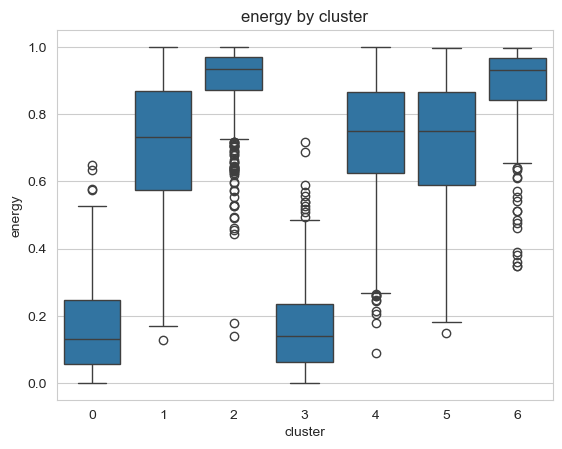

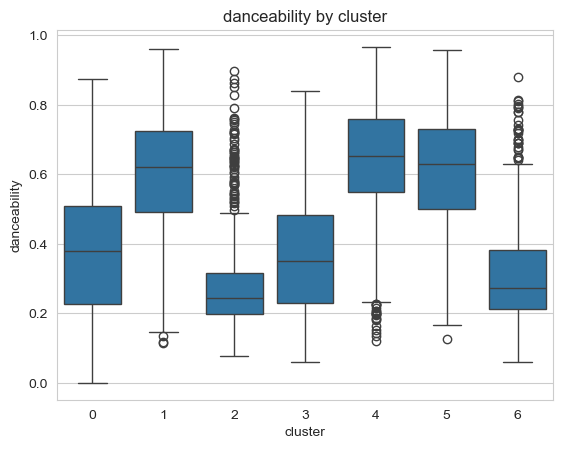

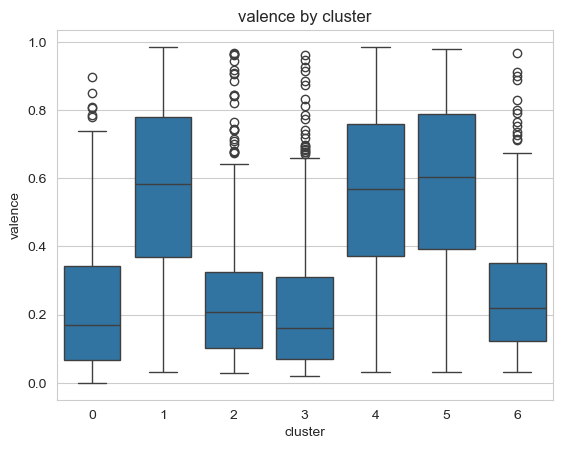

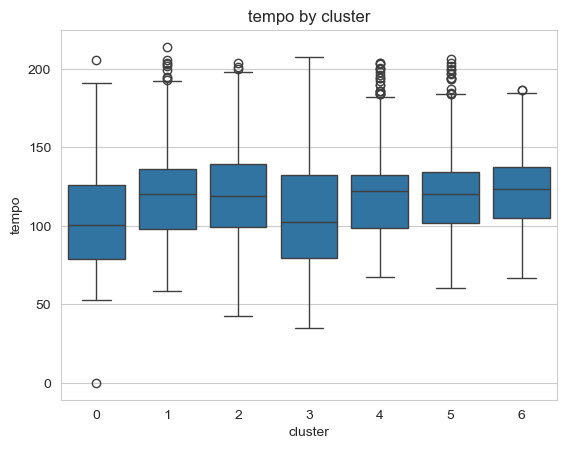

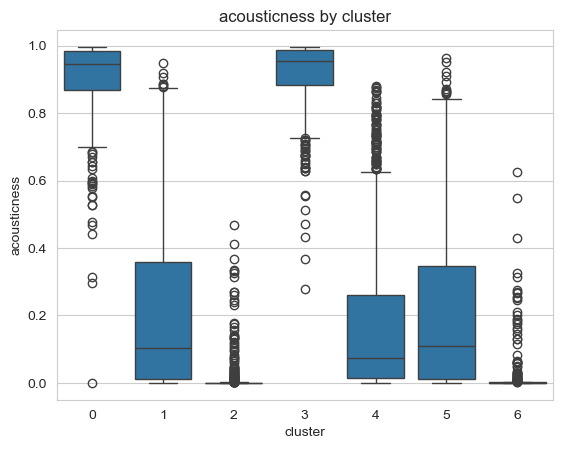

In [264]:
import seaborn as sns
import matplotlib.pyplot as plt

features = ["energy", "danceability", "valence", "tempo", "acousticness"]

for f in features:
    sns.boxplot(x="cluster", y=f, data=df_kmean)
    plt.title(f"{f} by cluster")
    plt.show()